In [439]:
from utils import *
from Visualization import *

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from typing import *
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.1.2+cu121
Torchvision Version:  0.16.2+cu121


In [662]:
input_size = (128,128)
data_dir = "./data/MIT_split"

key_execution = "scale_"+str(input_size)+"_unfroze3"
history[key_execution] = {"losses": None, "acc": None }

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 8


In [663]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}


In [664]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1881
     Root location: ./data/MIT_split/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(128, 128))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 807
     Root location: ./data/MIT_split/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(128, 128))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [665]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "test": []}
    losses = {"train": [], "test": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())
            losses[phase].append(epoch_loss)


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



def save_model(model_state_dict: object, path, filename:str) -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    torch.save(model_state_dict(), os.path.join(path, filename))


def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)


def SVM_Loss(output, weight, y_true, num_classes):
    y = F.one_hot(y_true, num_classes = num_classes).to(output.device)
    y[y!=1] = -1
    tmp = torch.zeros_like(y).to(y.device)
    regularizer = torch.mean(weight.T@weight)
    maximum = torch.maximum(tmp, 1 -  y * output )
    loss = torch.mean(maximum)
    
    return regularizer + loss * 0.2


In [666]:
class Efficient_net(nn.Module):
    def __init__(self, freeze= True):
        super(Efficient_net, self).__init__()
        
        self._freeze = freeze
        
        self._eff = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
        
        self.features = self._eff.features
        
        self.avgpool = self._eff.avgpool
        
        self.classifier = self._eff.classifier
        
        self.gradients = None
        
        self.set_parameter_requires_grad(freeze)
        
        
    def set_parameter_requires_grad(self, feature_extracting):
        if feature_extracting:
            for param in self.parameters():
                param.requires_grad = False


    def activate_gradients(self):
        for param in self.parameters():
            param.requires_grad = True


    def activate_marginal_gradients(self, indexing):
        for param in self.features[indexing:].parameters():
            param.requires_grad = True
        
    def forward(self, x):
        
        x = self.features(x)
        if not self._freeze:
            h = x.register_hook(self.activations_hook)
            self.gradients = h
            
        view = x.shape[:2]
        
        x = self.avgpool(x).view(view)
        x = self.classifier(x)
        
        
        return x
    
    def set_linear(self, output_size):
        self.classifier[-1] = nn.Linear(1280, output_size)
        
    def activations_hook(self, grad):
        print(grad)
        print("golaaa")
        self.gradients = grad
        
    def get_activations_gradient(self):
        return self.gradients
        
        

In [667]:
model = Efficient_net()
model.set_linear(num_classes)
model.activate_marginal_gradients(-3)

In [668]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(len(params_to_update))
# Observe that all parameters are being optimized

70


In [669]:
#model, _ = initialize_model(8)

In [670]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7842 Acc: 0.7326
test Loss: 0.3453 Acc: 0.9009

Epoch 1/14
----------
train Loss: 0.4674 Acc: 0.8485
test Loss: 0.3714 Acc: 0.8984

Epoch 2/14
----------
train Loss: 0.3414 Acc: 0.8836
test Loss: 0.2057 Acc: 0.9418

Epoch 3/14
----------
train Loss: 0.2761 Acc: 0.9086
test Loss: 0.2332 Acc: 0.9207

Epoch 4/14
----------
train Loss: 0.2211 Acc: 0.9224
test Loss: 0.2667 Acc: 0.9170

Epoch 5/14
----------
train Loss: 0.2156 Acc: 0.9304
test Loss: 0.2619 Acc: 0.9170

Epoch 6/14
----------
train Loss: 0.1665 Acc: 0.9516
test Loss: 0.4030 Acc: 0.8625

Epoch 7/14
----------
train Loss: 0.1327 Acc: 0.9575
test Loss: 0.2162 Acc: 0.9195

Epoch 8/14
----------
train Loss: 0.1508 Acc: 0.9506
test Loss: 0.2252 Acc: 0.9257

Epoch 9/14
----------
train Loss: 0.1372 Acc: 0.9596
test Loss: 0.2374 Acc: 0.9195

Epoch 10/14
----------
train Loss: 0.1000 Acc: 0.9676
test Loss: 0.2578 Acc: 0.9269

Epoch 11/14
----------
train Loss: 0.1237 Acc: 0.9612
test Loss: 0.2381 Acc

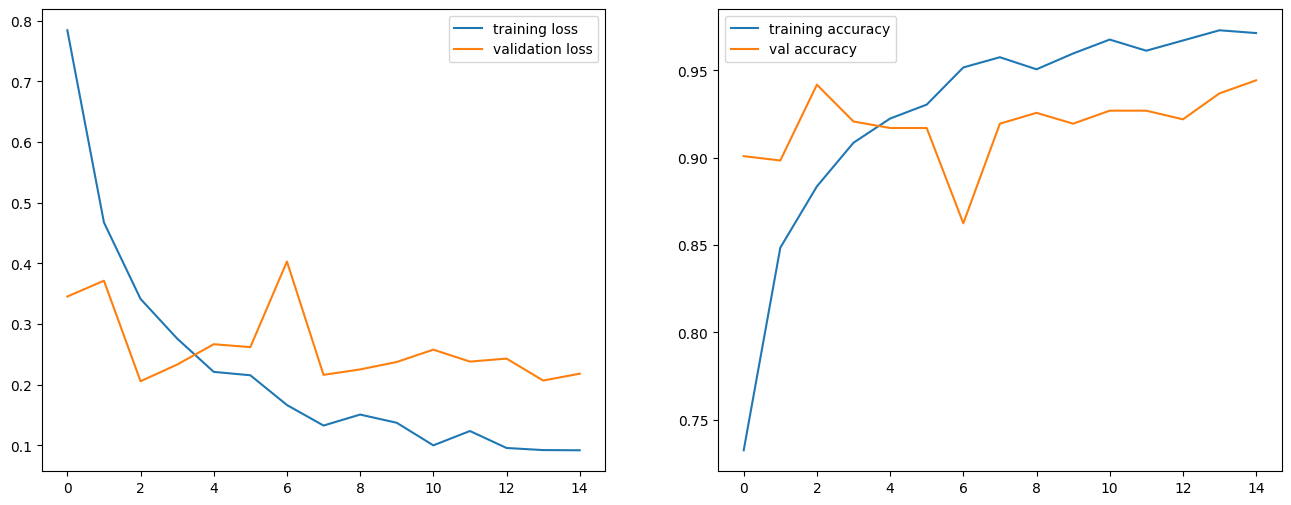

In [671]:
### plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["test"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["test"],label="val accuracy")
ax2.legend()

plt.show()  

In [672]:
history[key_execution]["losses"] = losses
history[key_execution]["acc"] = hist
save_model(model.state_dict, filename=key_execution+".pt", path="./checkpoints/eff")

In [673]:
write_pickle(filepath="./results_per_patch_unfreeze.pkl", information=history) 

In [674]:
pd.DataFrame().from_dict(history)

,"scale_(224, 224)","scale_(256, 256)","scale_(64, 64)","scale_(64, 64)_unfroze2","scale_(96, 96)_unfroze2","scale_(128, 128)_unfroze2","scale_(224, 224)_unfroze2","scale_(256, 256)_unfroze2","scale_(96, 96)_unfroze3","scale_(64, 64)_unfroze3","scale_(224, 224)_unfroze3","scale_(256, 256)_unfroze3","scale_(64, 64)_unfroze4","scale_(96, 96)_unfroze4","scale_(128, 128)_unfroze4","scale_(224, 224)_unfroze4","scale_(256, 256)_unfroze4","scale_(96, 96)","scale_(128, 128)","scale_(128, 128)_unfroze3"
losses,"{'train': [1.1070966000001776, 0.6444805593074...","{'train': [0.7467393879558354, 0.3316147294309...","{'train': [1.3742146296807898, 1.0240656406812...","{'train': [1.059318637543698, 0.77412178603846...","{'train': [0.8697765666331971, 0.5391748872828...","{'train': [0.7793164124899503, 0.4939892874443...","{'train': [0.6411854407528751, 0.3784423637253...","{'train': [0.6283057428369618, 0.3397499921472...","{'train': [0.8627822192852197, 0.5143444289209...","{'train': [1.054559043878447, 0.76655684367955...","{'train': [0.7099033174427313, 0.3935418844555...","{'train': [0.6488837300305161, 0.3646573498845...","{'train': [1.0724596823231456, 0.7149613610231...","{'train': [0.8673630722148313, 0.5692687609422...","{'train': [0.773954703445323, 0.46357481426409...","{'train': [0.7019250849217319, 0.4222055584556...","{'train': [0.7026432035198749, 0.3609416808483...","{'train': [1.2342316759576955, 0.8181457306589...","{'train': [1.1605477748812036, 0.7444354996663...","{'train': [0.7842302870110335, 0.4673917661284..."
acc,"{'train': [0.6810207336523126, 0.8054226475279...","{'train': [0.7729930887825626, 0.8904837852206...","{'train': [0.5380116959064328, 0.6443381180223...","{'train': [0.634768740031898, 0.74056353003721...","{'train': [0.7150451887293993, 0.8155236576289...","{'train': [0.7288676236044658, 0.8309409888357...","{'train': [0.7894736842105263, 0.8745348219032...","{'train': [0.7830940988835726, 0.8910154173312...","{'train': [0.710260499734184, 0.83519404572036...","{'train': [0.6501860712387029, 0.7421584263689...","{'train': [0.7745879851143009, 0.8686868686868...","{'train': [0.7862838915470495, 0.8814460393407...","{'train': [0.6491228070175439, 0.7729930887825...","{'train': [0.7161084529505582, 0.8086124401913...","{'train': [0.7363104731525785, 0.8341307814992...","{'train': [0.7783094098883573, 0.8681552365762...","{'train': [0.7692716640085062, 0.8755980861244...","{'train': [0.6145667198298778, 0.7309941520467...","{'train': [0.6586921850079746, 0.7612971823498...","{'train': [0.7325890483785221, 0.8484848484848..."


In [675]:
print(history.keys())

dict_keys(['scale_(224, 224)', 'scale_(256, 256)', 'scale_(64, 64)', 'scale_(64, 64)_unfroze2', 'scale_(96, 96)_unfroze2', 'scale_(128, 128)_unfroze2', 'scale_(224, 224)_unfroze2', 'scale_(256, 256)_unfroze2', 'scale_(96, 96)_unfroze3', 'scale_(64, 64)_unfroze3', 'scale_(224, 224)_unfroze3', 'scale_(256, 256)_unfroze3', 'scale_(64, 64)_unfroze4', 'scale_(96, 96)_unfroze4', 'scale_(128, 128)_unfroze4', 'scale_(224, 224)_unfroze4', 'scale_(256, 256)_unfroze4', 'scale_(96, 96)', 'scale_(128, 128)', 'scale_(128, 128)_unfroze3'])


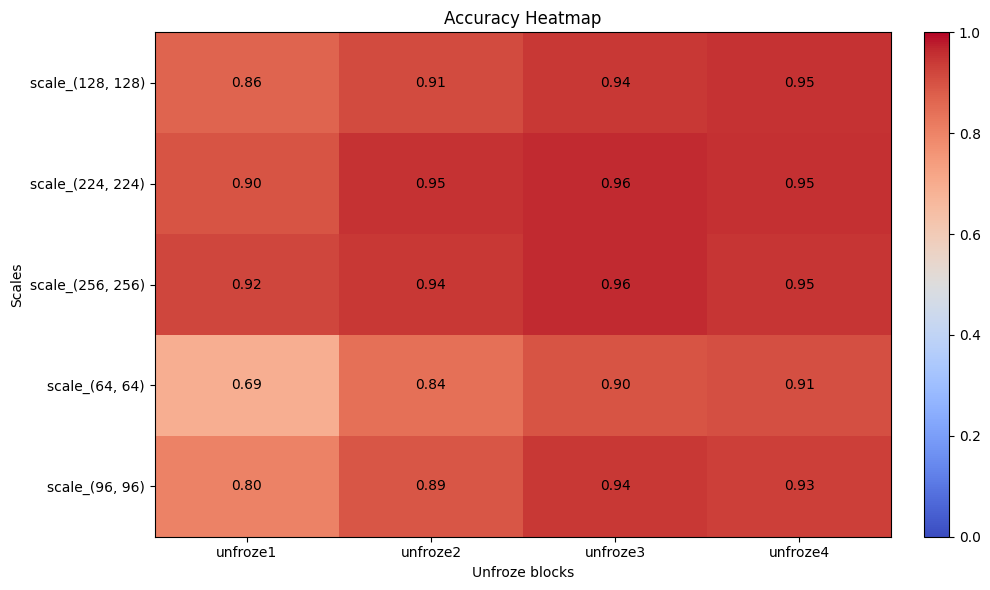

In [676]:
import matplotlib.pyplot as plt
import numpy as np

# Ejemplo de diccionario de datos
data = copy.copy(history)
# Extraer las escalas y los unfroze<int>
scales = set()
unfroze_values = set()

for key in data.keys():
    if len(key.split("_")) < 3:
        scale = key
        unfroze = 1
    else:
        scale, unfroze = key.split('_unfroze')
    scales.add(scale)
    unfroze_values.add(int(unfroze))

# Ordenar las escalas y los unfroze<int>
scales = sorted(list(scales))
unfroze_values = sorted(list(unfroze_values))

# Crear un solo heatmap para el accuracy
heatmap_data_accuracy = np.zeros((len(scales), len(unfroze_values)))

for i, scale in enumerate(scales):
    for j, unfroze in enumerate(unfroze_values):
        if unfroze == 1:
            
            key = f"{scale}"
        else:
            key = f"{scale}_unfroze{unfroze}"
            
        if key in data:
            heatmap_data_accuracy[i, j] = np.max(data[key]['acc']["test"])

# Crear el heatmap
fig, ax = plt.subplots(figsize=(10, 6))

im_accuracy = ax.imshow(heatmap_data_accuracy, cmap='coolwarm', vmin=0, vmax=1, aspect='auto', origin='upper')


# Añadir anotaciones
for i in range(len(scales)):
    for j in range(len(unfroze_values)):
        value = heatmap_data_accuracy[i, j]
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')


ax.set_title('Accuracy Heatmap')
ax.set_xticks(np.arange(len(unfroze_values)))
ax.set_xticklabels([f'unfroze{unfroze}' for unfroze in unfroze_values])
ax.set_yticks(np.arange(len(scales)))
ax.set_yticklabels(scales)
ax.set_xlabel('Unfroze blocks')
ax.set_ylabel('Scales')
fig.colorbar(im_accuracy, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



In [432]:
import pandas as pd
import seaborn as sns

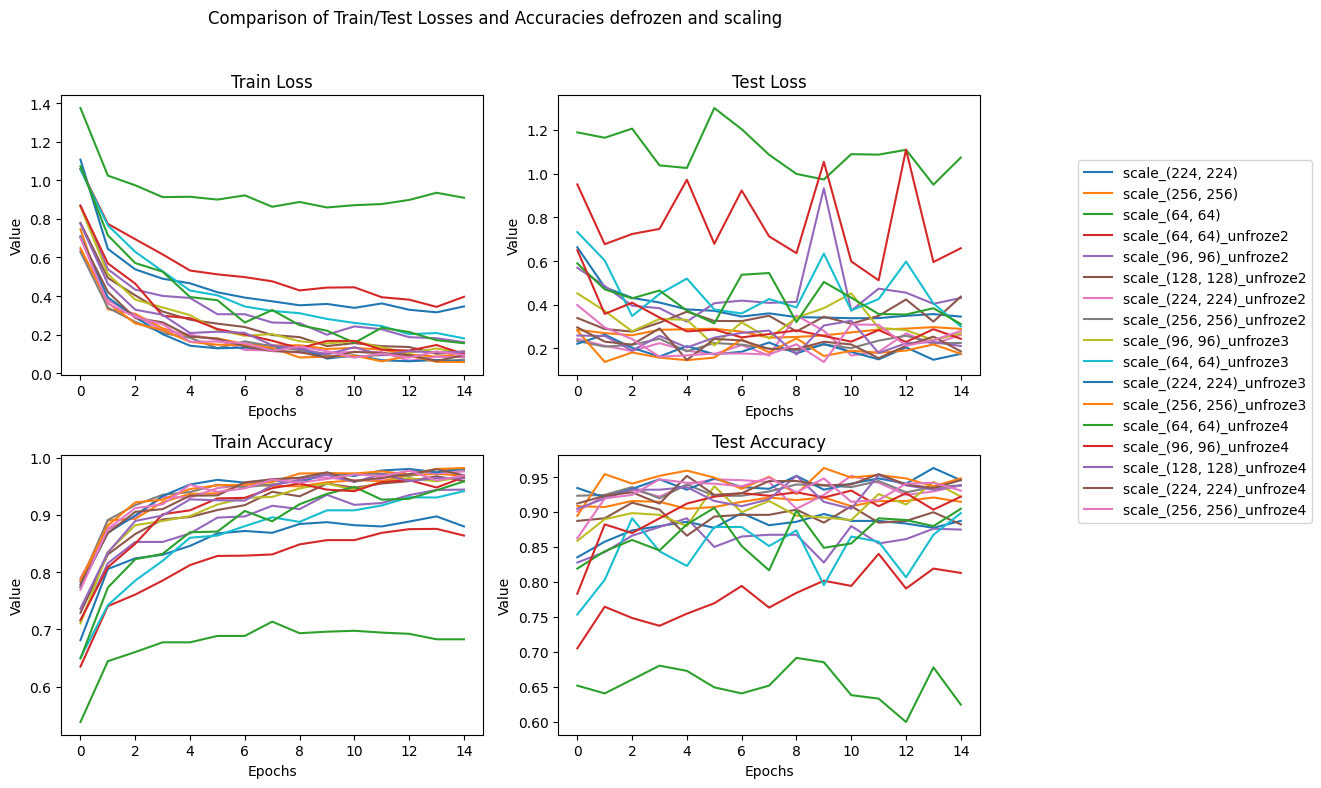

In [451]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Comparison of Train/Test Losses and Accuracies defrozen and scaling')

# Iterate over each key in the dictionary
for i, (key, values) in enumerate(history.items()):
    # Train Loss plot
    axs[0, 0].plot(values['losses']['train'], label=key)
    axs[0, 0].set_title('Train Loss')

    # Test Loss plot
    axs[0, 1].plot(values['losses']['test'], label=key)
    axs[0, 1].set_title('Test Loss')

    # Train Accuracy plot
    axs[1, 0].plot(values['acc']['train'], label=key)
    axs[1, 0].set_title('Train Accuracy')

    # Test Accuracy plot
    axs[1, 1].plot(values['acc']['test'], label=key)
    axs[1, 1].set_title('Test Accuracy')

# Add legends and labels
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 0.8))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

In [ ]:
write

## Applying GradCam adn explainability

In [610]:
@torch.no_grad()  # prevent this function from computing gradients 
def get_mistakes(model, loader):
    

    val_loss = 0
    correct = 0

    model.eval()
    final_images = []
    final_targets =  []
    errors_im = []
    predictions = []

    for data, target in loader:
        data, target = data.to(device), target.to(device)
    
        output = model(data)
        p = F.softmax(output, dim=1)
        scr, pred = p.data.max(1, keepdim=True) # get the index of the max log-probability   
        
        predictions += (list(pred.cpu().numpy()))
        correct += pred.eq(target.view_as(pred)).sum().item()
        non_correcte = (pred != target.view_as(pred)).squeeze() 
        image_indexes = data[non_correcte,:,:,:]
        image_targets = target[non_correcte]

        errors = pred[non_correcte]
    
        final_images.append(image_indexes.cpu())
        final_targets.append(image_targets.cpu().numpy())
        errors_im.append(errors.cpu().numpy())

    return final_images, final_targets, errors_im

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, preds = torch.max(outputs, 1)
    

    
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
        
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))




In [472]:
validate(model=model, criterion=criterion, loader=dataloaders_dict["test"])

test Loss: 0.2360 Acc: 0.9442


images = []
y_test = []
for i in image_datasets["test"].imgs:
    
    img = torchvision.io.read_image(i[0])
    images.append(img.float())
    y_test.append(i[-1])

images = torch.tensor(np.array(images)).to(device)
y_test = torch.tensor(np.array(y_test)).to(device)


In [473]:
#model._freeze = True
misatke_images, gt, predictions = get_mistakes(model=model, loader=dataloaders_dict["test"])

In [611]:
def tensor_to_image(img):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                         std = [ 1., 1., 1. ]),
                                   ])
    img = invTrans(img)
    img = img.permute(1, 2, 0) 
    img = (img.numpy()*255).astype(np.uint8)
    return img #Image.fromarray(tensor, "RGB")

convert_tensor = transforms.ToTensor()

inverse_mapping_classes = {j:i for i, j in dataloaders_dict["test"].dataset.class_to_idx.items()}

In [497]:
prediction_test = predictions[2][0]
image_test = tensor_to_image(misatke_images[2][0])
gt_test = gt[2][0]

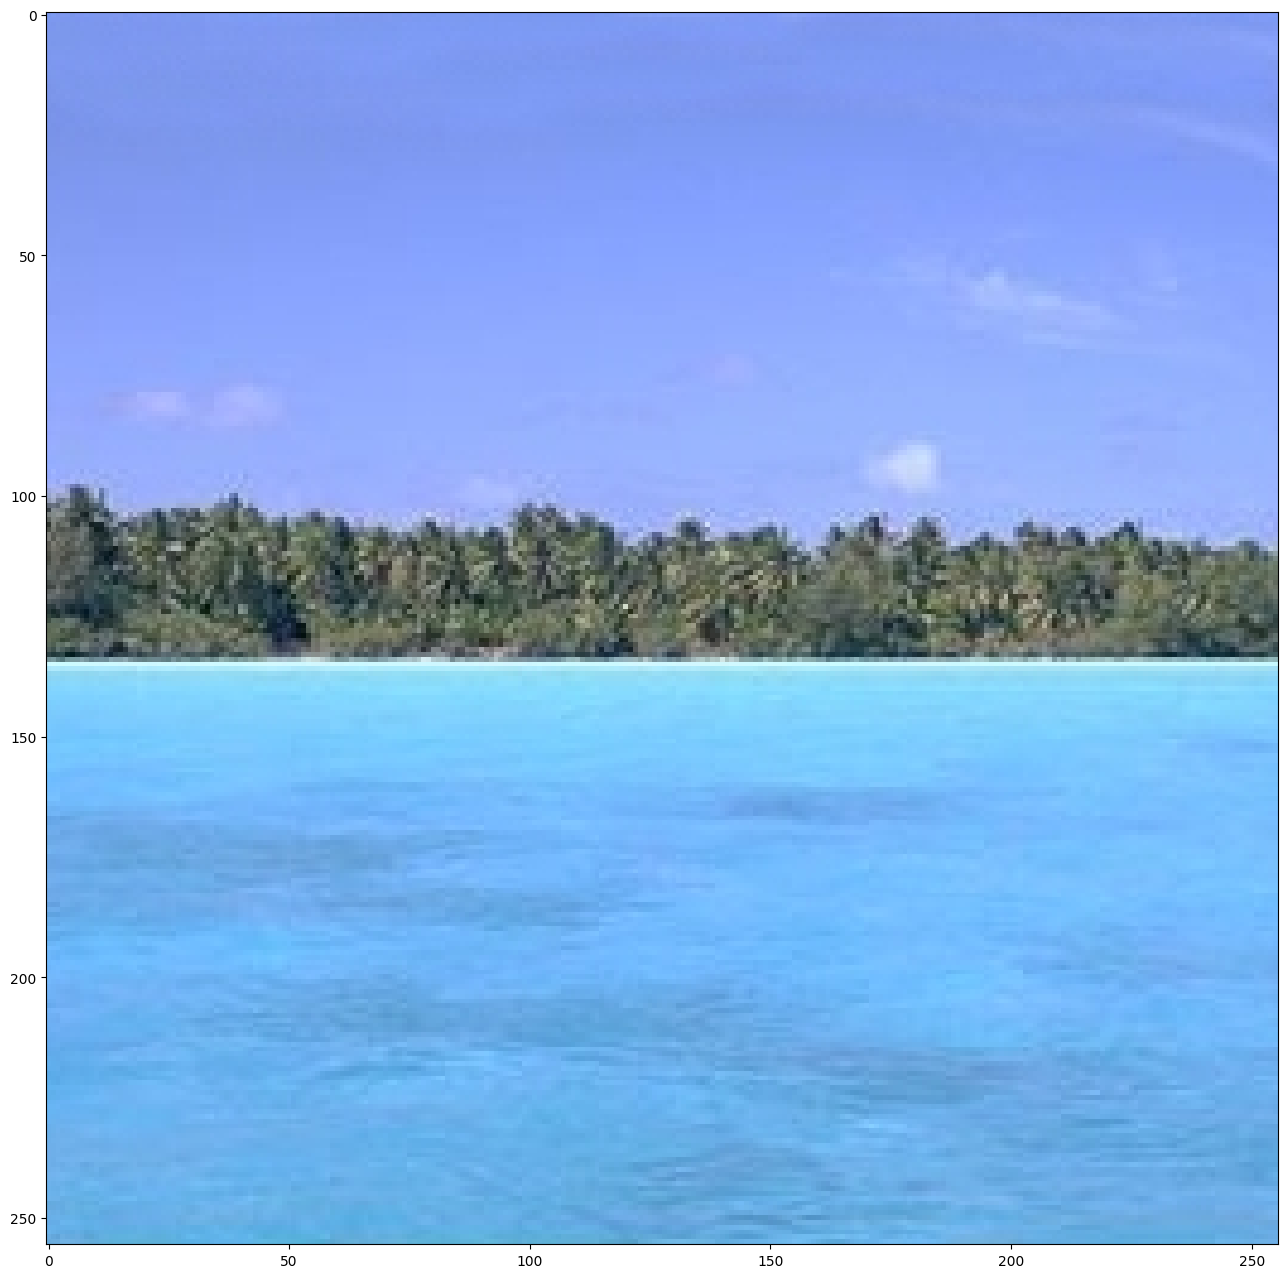

In [498]:
plt.imshow(image_test)

In [590]:
model_traced = module2traced(model, misatke_images[2][0].unsqueeze(0).cuda())

In [591]:
from Visualization.Weights import *

vis = Weights(model, device)

In [592]:
len(model_traced)

446

In [604]:
first_layer = model_traced[6]

In [605]:
first_layer

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

In [606]:
plt.rcParams["figure.figsize"]= 16,16

In [607]:
inverse_mapping_classes[prediction_test[-1]], inverse_mapping_classes[gt_test]

('Opencountry', 'coast')

torch.Size([1, 128, 128])


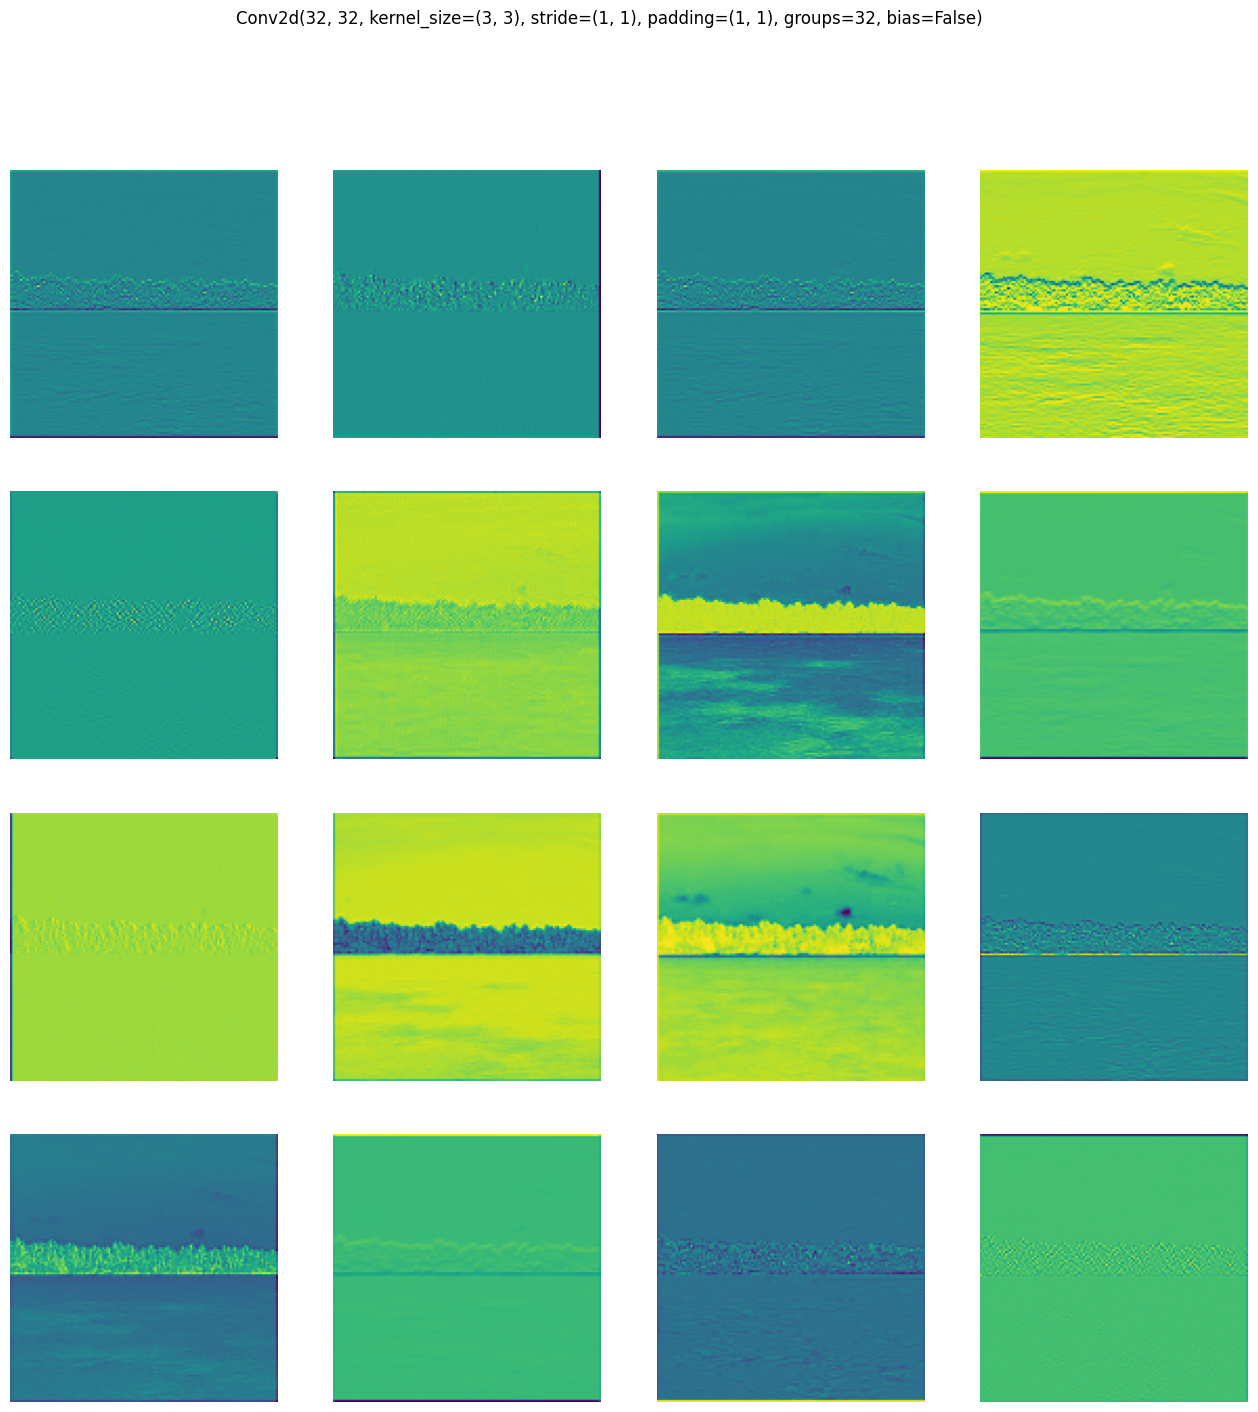

In [612]:
run_vis_plot(vis,convert_tensor(image_test).unsqueeze(0).cuda(), first_layer, ncols=4, nrows=4)